In [ ]:
import pandas as pd
import numpy as np
import os
import subprocess

os.environ["PATH"] = "/home/b/b37974/:" + os.environ["PATH"]

def run_command(command):
    """Run a shell command (tuple/list or string) and return the output."""
    if isinstance(command, (tuple, list)):
        result = subprocess.run(command, capture_output=True, text=True)
    else:
        result = subprocess.run(command, shell=True, capture_output=True, text=True)

    if result.returncode != 0:
        raise RuntimeError(f"Command failed:\n{command}\n{result.stderr}")
    return result.stdout.strip()

bed_prefix = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_agp3k/wgs/14.hwe_qc/cteph_agp3k.s_qc.gt_qc.v_qc.hwe"
sample_keep = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_agp3k/wgs/16.bbj_projection_sample_keep/CTEPH_AGP3K.bbj_projection.subset.keep.txt"
prune_in = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_agp3k/wgs/15.pca/cteph_agp3k.s_qc.gt_qc.v_qc.hwe.pass.hwe.maf0.01.no_high_ld.prune.in"

subset_prefix = "projection_keep"
out_prefix = "test_kinship"

subset_command = [
    "/home/b/b37974/plink2",
    "--bfile", bed_prefix,
    "--keep", sample_keep,
    "--make-bed",
    "--out", subset_prefix,
    "--threads", "8"
]

# run_command(subset_command)

In [2]:
kinship_command = [
    "/home/b/b37974/plink",
    "--bfile", subset_prefix,
    "--extract", prune_in,
    "--genome",
    "--out", out_prefix,
]

# run_command(kinship_command)

In [3]:
genome_file = f"{out_prefix}.genome"
cols_to_use = ["IID1", "IID2", "PI_HAT"]

pi_hat_threshold = 0.20

filtered_rows = []
with open(genome_file, "r") as f:
    header = f.readline().strip().split()
    col_idx = [header.index(col) for col in cols_to_use]
    pi_hat_idx = header.index("PI_HAT")
    for line in f:
        fields = line.strip().split()
        pi_hat_val = round(float(fields[pi_hat_idx]), 3)
        if pi_hat_val > pi_hat_threshold:
            row = [fields[i] for i in col_idx]
            row[cols_to_use.index("PI_HAT")] = f"{pi_hat_val:.3f}"
            filtered_rows.append(row)

kinship_df = pd.DataFrame(filtered_rows, columns=cols_to_use)
kinship_df["PI_HAT"] = pd.to_numeric(kinship_df["PI_HAT"])
kinship_node = list(set(kinship_df["IID1"]).union(set(kinship_df["IID2"])))

In [4]:
smiss_command = [
    "/home/b/b37974/plink2",
    "--bfile", bed_prefix,
    "--missing", "sample-only", 
    "--out", out_prefix,
    "--threads", "8"
]

# run_command(smiss_command)

smiss_file = f"{out_prefix}.smiss"
iid_fmiss = []
with open(smiss_file, "r") as f:
    header = f.readline().strip().split()
    iid_idx = header.index("IID")
    fmiss_idx = header.index("F_MISS")
    for line in f:
        fields = line.strip().split()
        if fields[iid_idx] in kinship_node:
            iid_fmiss.append([fields[iid_idx], fields[fmiss_idx]])

smiss_df = pd.DataFrame(iid_fmiss, columns=["IID", "F_MISS"])
smiss_df["F_MISS"] = pd.to_numeric(smiss_df["F_MISS"])

In [5]:
kinship_df.to_csv(f"{out_prefix}.kinship.csv", index=False)
smiss_df.to_csv(f"{out_prefix}.smiss.csv", index=False)

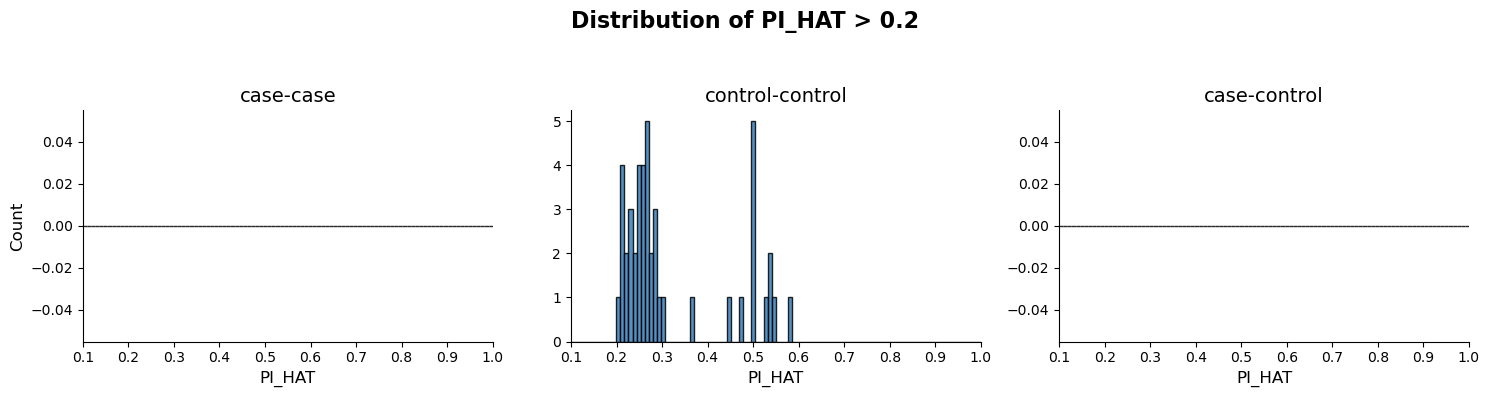

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

case_prefix = "PHOM"

# 分类标签
def get_case_status(iid):
    return "case" if iid.startswith(case_prefix) else "control"

kinship_df["IID1_status"] = kinship_df["IID1"].apply(get_case_status)
kinship_df["IID2_status"] = kinship_df["IID2"].apply(get_case_status)

def kinship_type(row):
    if row["IID1_status"] == "case" and row["IID2_status"] == "case":
        return "case-case"
    elif row["IID1_status"] == "control" and row["IID2_status"] == "control":
        return "control-control"
    else:
        return "case-control"

kinship_df["pair_type"] = kinship_df.apply(kinship_type, axis=1)

# 配色与排布
pair_types = ["case-case", "control-control", "case-control"]
colors = {"case-case": "#e41a1c", "control-control": "#377eb8", "case-control": "#4daf4a"}

# 美化配置
plt.style.use("default")
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

x_min = max(pi_hat_threshold - 0.1, 0.1)
x_max = 1.0

# 画图
for ax, pair in zip(axes, pair_types):
    data = kinship_df.loc[kinship_df["pair_type"] == pair, "PI_HAT"]
    ax.hist(data, bins=100, alpha=0.85, range=(x_min, x_max), color=colors[pair], edgecolor='black')
    ax.set_title(pair, fontsize=14)
    ax.set_xlabel("PI_HAT")
    ax.set_xlim(x_min, x_max)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Count", fontsize=12)
fig.suptitle(f"Distribution of PI_HAT > {pi_hat_threshold}", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

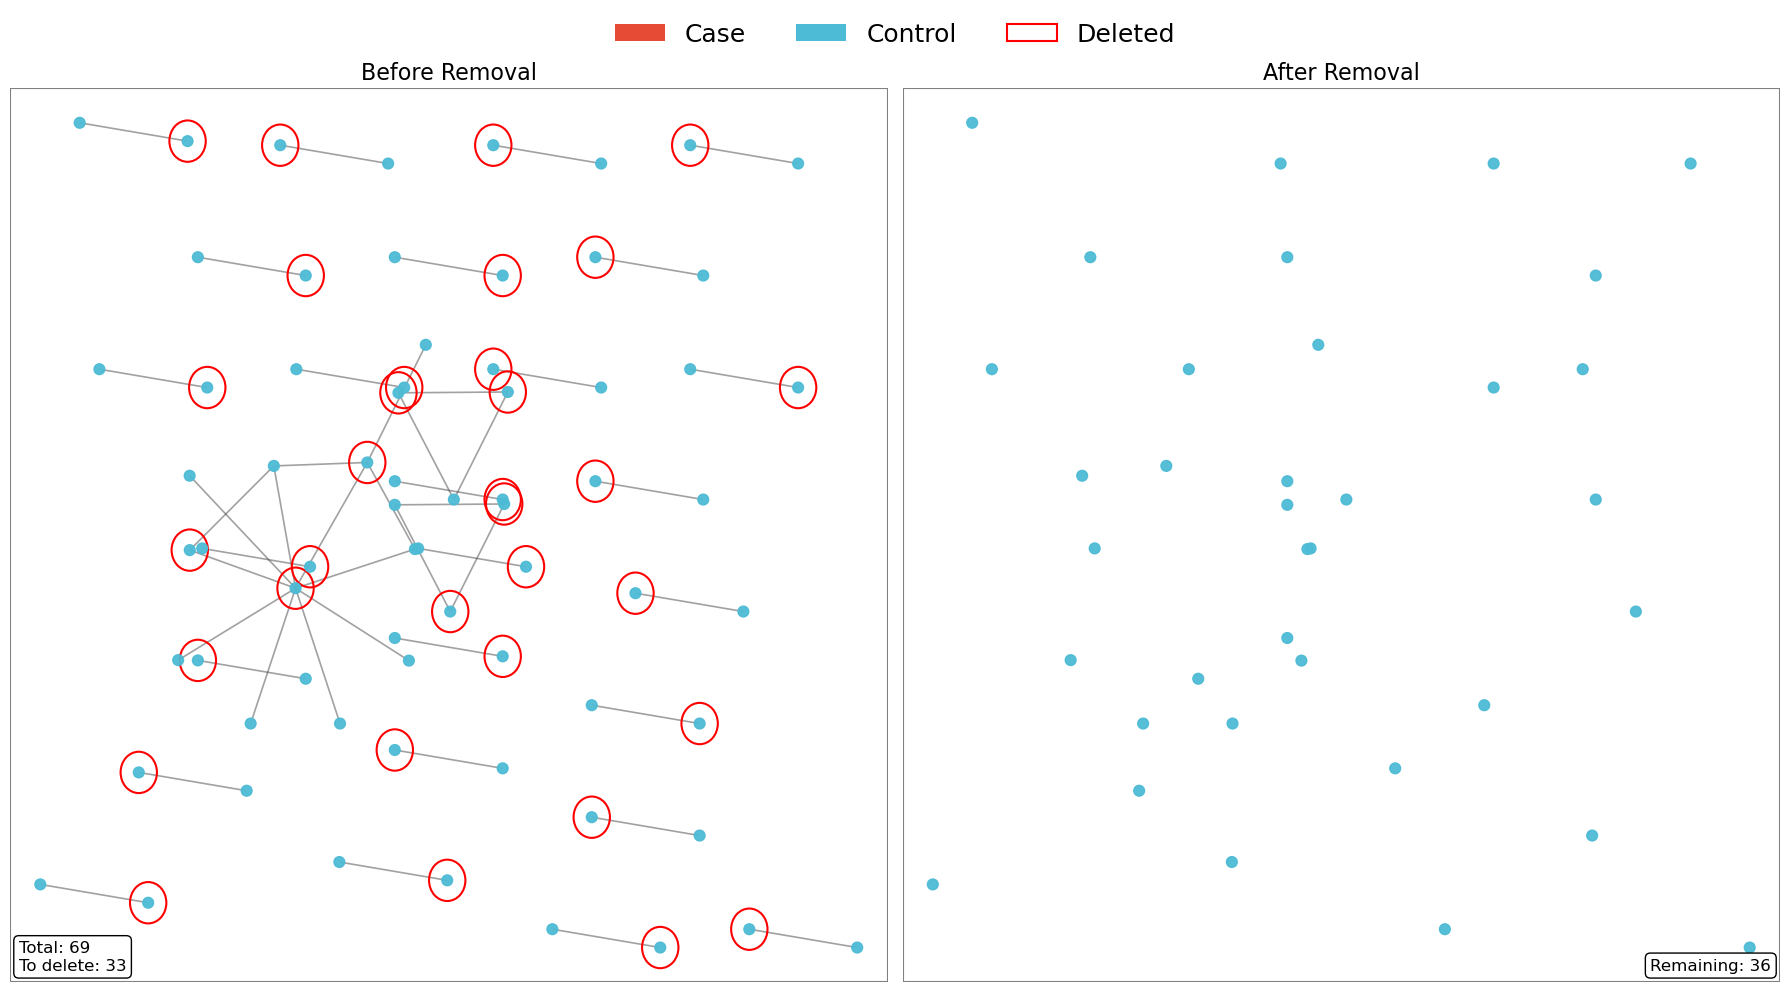

✅ 删除了 33 个节点


In [16]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle, Rectangle
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.algorithms.approximation import min_weighted_vertex_cover


case_prefix = "PHOM"

# ==== 构建无权图 ====
G_all = nx.Graph()
for iid in set(kinship_df["IID1"]).union(set(kinship_df["IID2"])):
    status = "case" if iid.startswith(case_prefix) else "control"
    G_all.add_node(iid, status=status)

for _, row in kinship_df.iterrows():
    G_all.add_edge(row["IID1"], row["IID2"])

# ==== 构建 F_MISS 字典 ====
smiss_dict = dict(zip(smiss_df['IID'], smiss_df['F_MISS']))

# ==== 设置权重：case = inf，control = 1 / F_MISS ====
for n in G_all.nodes:
    if G_all.nodes[n]["status"] == "case":
        G_all.nodes[n]["weight"] = float("inf")
    else:
        fmiss = smiss_dict.get(n, 0.001)  # 避免除 0
        G_all.nodes[n]["weight"] = 1.0 / fmiss # the smaller the F_MISS, the larger the weight

# ==== 计算近似最小加权顶点覆盖 ====
vc = min_weighted_vertex_cover(G_all, weight="weight")
to_remove = set(vc)
remaining_nodes = set(G_all.nodes) - to_remove

# ==== 布局与颜色映射 ====
pos = graphviz_layout(G_all, prog="neato")
color_map = {"case": "#E64B35", "control": "#4DBBD5"}
node_colors_before = [color_map[G_all.nodes[n]["status"]] for n in G_all.nodes]
node_colors_after = [color_map[G_all.nodes[n]["status"]] for n in remaining_nodes]

legend_elements = [
    Patch(facecolor='#E64B35', label='Case'),
    Patch(facecolor='#4DBBD5', label='Control'),
    Patch(edgecolor='red', facecolor='none', label='Deleted', linewidth=1.5)
]

# ==== 框选区域计算 ====
x_vals = [p[0] for p in pos.values()]
y_vals = [p[1] for p in pos.values()]
pad = 20
x_min, x_max = min(x_vals)-pad, max(x_vals)+pad
y_min, y_max = min(y_vals)-pad, max(y_vals)+pad

# ==== 绘图 ====
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# ==== 统计信息 ====
total_nodes = len(G_all.nodes)
deleted_nodes = len(to_remove)
remaining_nodes_count = len(remaining_nodes)

# --- 左图：删除前 ---
ax = axes[0]
ax.set_title("Before Removal", fontsize=16)
nx.draw_networkx_nodes(G_all, pos, node_color=node_colors_before, node_size=60, alpha=0.95, ax=ax)
nx.draw_networkx_edges(G_all, pos, edge_color="#444444", width=1.2, alpha=0.5, ax=ax)
for node in to_remove:
    if node in pos:
        x, y = pos[node]
        ax.add_patch(Circle((x, y), radius=12, fill=False, edgecolor='red', linewidth=1.5))
ax.add_patch(Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                       fill=False, edgecolor='gray', linewidth=1.5))
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis('off')

# 添加统计注释（左图下方）
ax.text(
    0.01, 0.01,
    f"Total: {total_nodes}\nTo delete: {deleted_nodes}",
    transform=ax.transAxes,
    ha='left', va='bottom',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
)

# --- 右图：删除后 ---
ax = axes[1]
ax.set_title("After Removal", fontsize=16)
G_final = nx.Graph()
for n in remaining_nodes:
    G_final.add_node(n, status=G_all.nodes[n]["status"])
nx.draw_networkx_nodes(G_final, pos, node_color=node_colors_after, node_size=60, alpha=0.95, ax=ax)
ax.add_patch(Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                       fill=False, edgecolor='gray', linewidth=1.5))
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis('off')

# 添加统计注释（右图下方）
ax.text(
    0.99, 0.01,
    f"Remaining: {remaining_nodes_count}",
    transform=ax.transAxes,
    ha='right', va='bottom',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
)

# --- 图例 ---
fig.legend(handles=legend_elements, loc="upper center", ncol=3, fontsize=18, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ==== 保存删除节点列表 ====
to_remove_df = pd.DataFrame(sorted(to_remove))
print(f"✅ 删除了 {len(to_remove)} 个节点")